In [134]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
import shap

In [136]:
# Import and review data

data = pd.read_csv('data.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tension_strenght    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7
5,0.02,10,40,honeycomb,200,60,40,pla,0,60,24,1.1
6,0.02,5,10,grid,205,65,40,pla,25,55,12,1.3
7,0.02,10,10,honeycomb,210,70,40,pla,50,21,14,1.5
8,0.02,9,70,grid,215,75,40,pla,75,24,27,1.4
9,0.02,8,40,honeycomb,220,80,40,pla,100,30,25,1.7


In [138]:
# Modeling Preparation

# Convert Categorical Calues to Numerical Values
pd.set_option('future.no_silent_downcasting', True)
data['infill_pattern'] = data['infill_pattern'].replace({'grid': 0, 'honeycomb': 1}).astype(int)
data['material'] = data['material'].replace({'abs': 0, 'pla': 1}).astype(int)
data.head(10)

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7
5,0.02,10,40,1,200,60,40,1,0,60,24,1.1
6,0.02,5,10,0,205,65,40,1,25,55,12,1.3
7,0.02,10,10,1,210,70,40,1,50,21,14,1.5
8,0.02,9,70,0,215,75,40,1,75,24,27,1.4
9,0.02,8,40,1,220,80,40,1,100,30,25,1.7


In [140]:
# Check for Duplicates, Null Values, Outliers

# Check for Duplicates in Each Column
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Check for Null Values in Each Column
null_values = data.isnull().sum()
print("Null values in each column:\n", null_values)

# Check for Outliers in Each Column
def detect_outliers_iqr(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
    return outliers

numeric_cols = data.select_dtypes(include=np.number)
outliers = detect_outliers_iqr(numeric_cols)
print("Outliers detected in each column:\n", outliers)

Number of duplicate rows: 0
Null values in each column:
 layer_height          0
wall_thickness        0
infill_density        0
infill_pattern        0
nozzle_temperature    0
bed_temperature       0
print_speed           0
material              0
fan_speed             0
roughness             0
tension_strenght      0
elongation            0
dtype: int64
Outliers detected in each column:
 layer_height           0
wall_thickness         0
infill_density         0
infill_pattern         0
nozzle_temperature     0
bed_temperature        0
print_speed           10
material               0
fan_speed              0
roughness              0
tension_strenght       0
elongation             0
dtype: int64


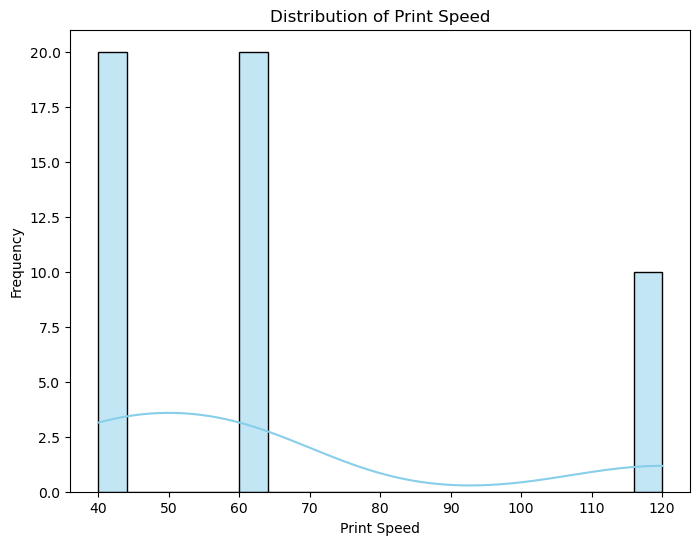

In [142]:
# Visualizing Distribution of Outlier Print Speed
plt.figure(figsize=(8, 6))
sns.histplot(data['print_speed'], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Print Speed")
plt.xlabel("Print Speed")
plt.ylabel("Frequency")
plt.show()

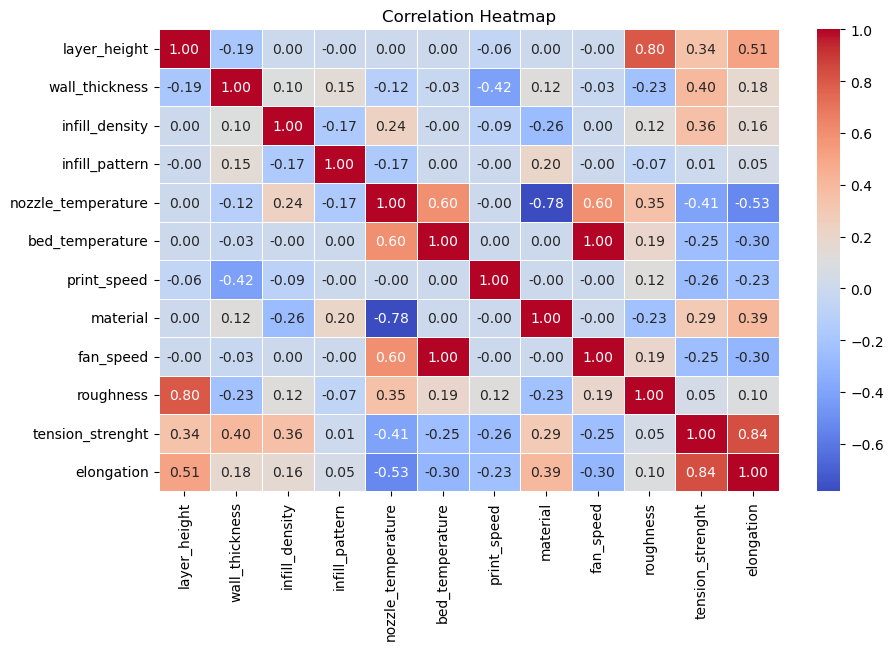

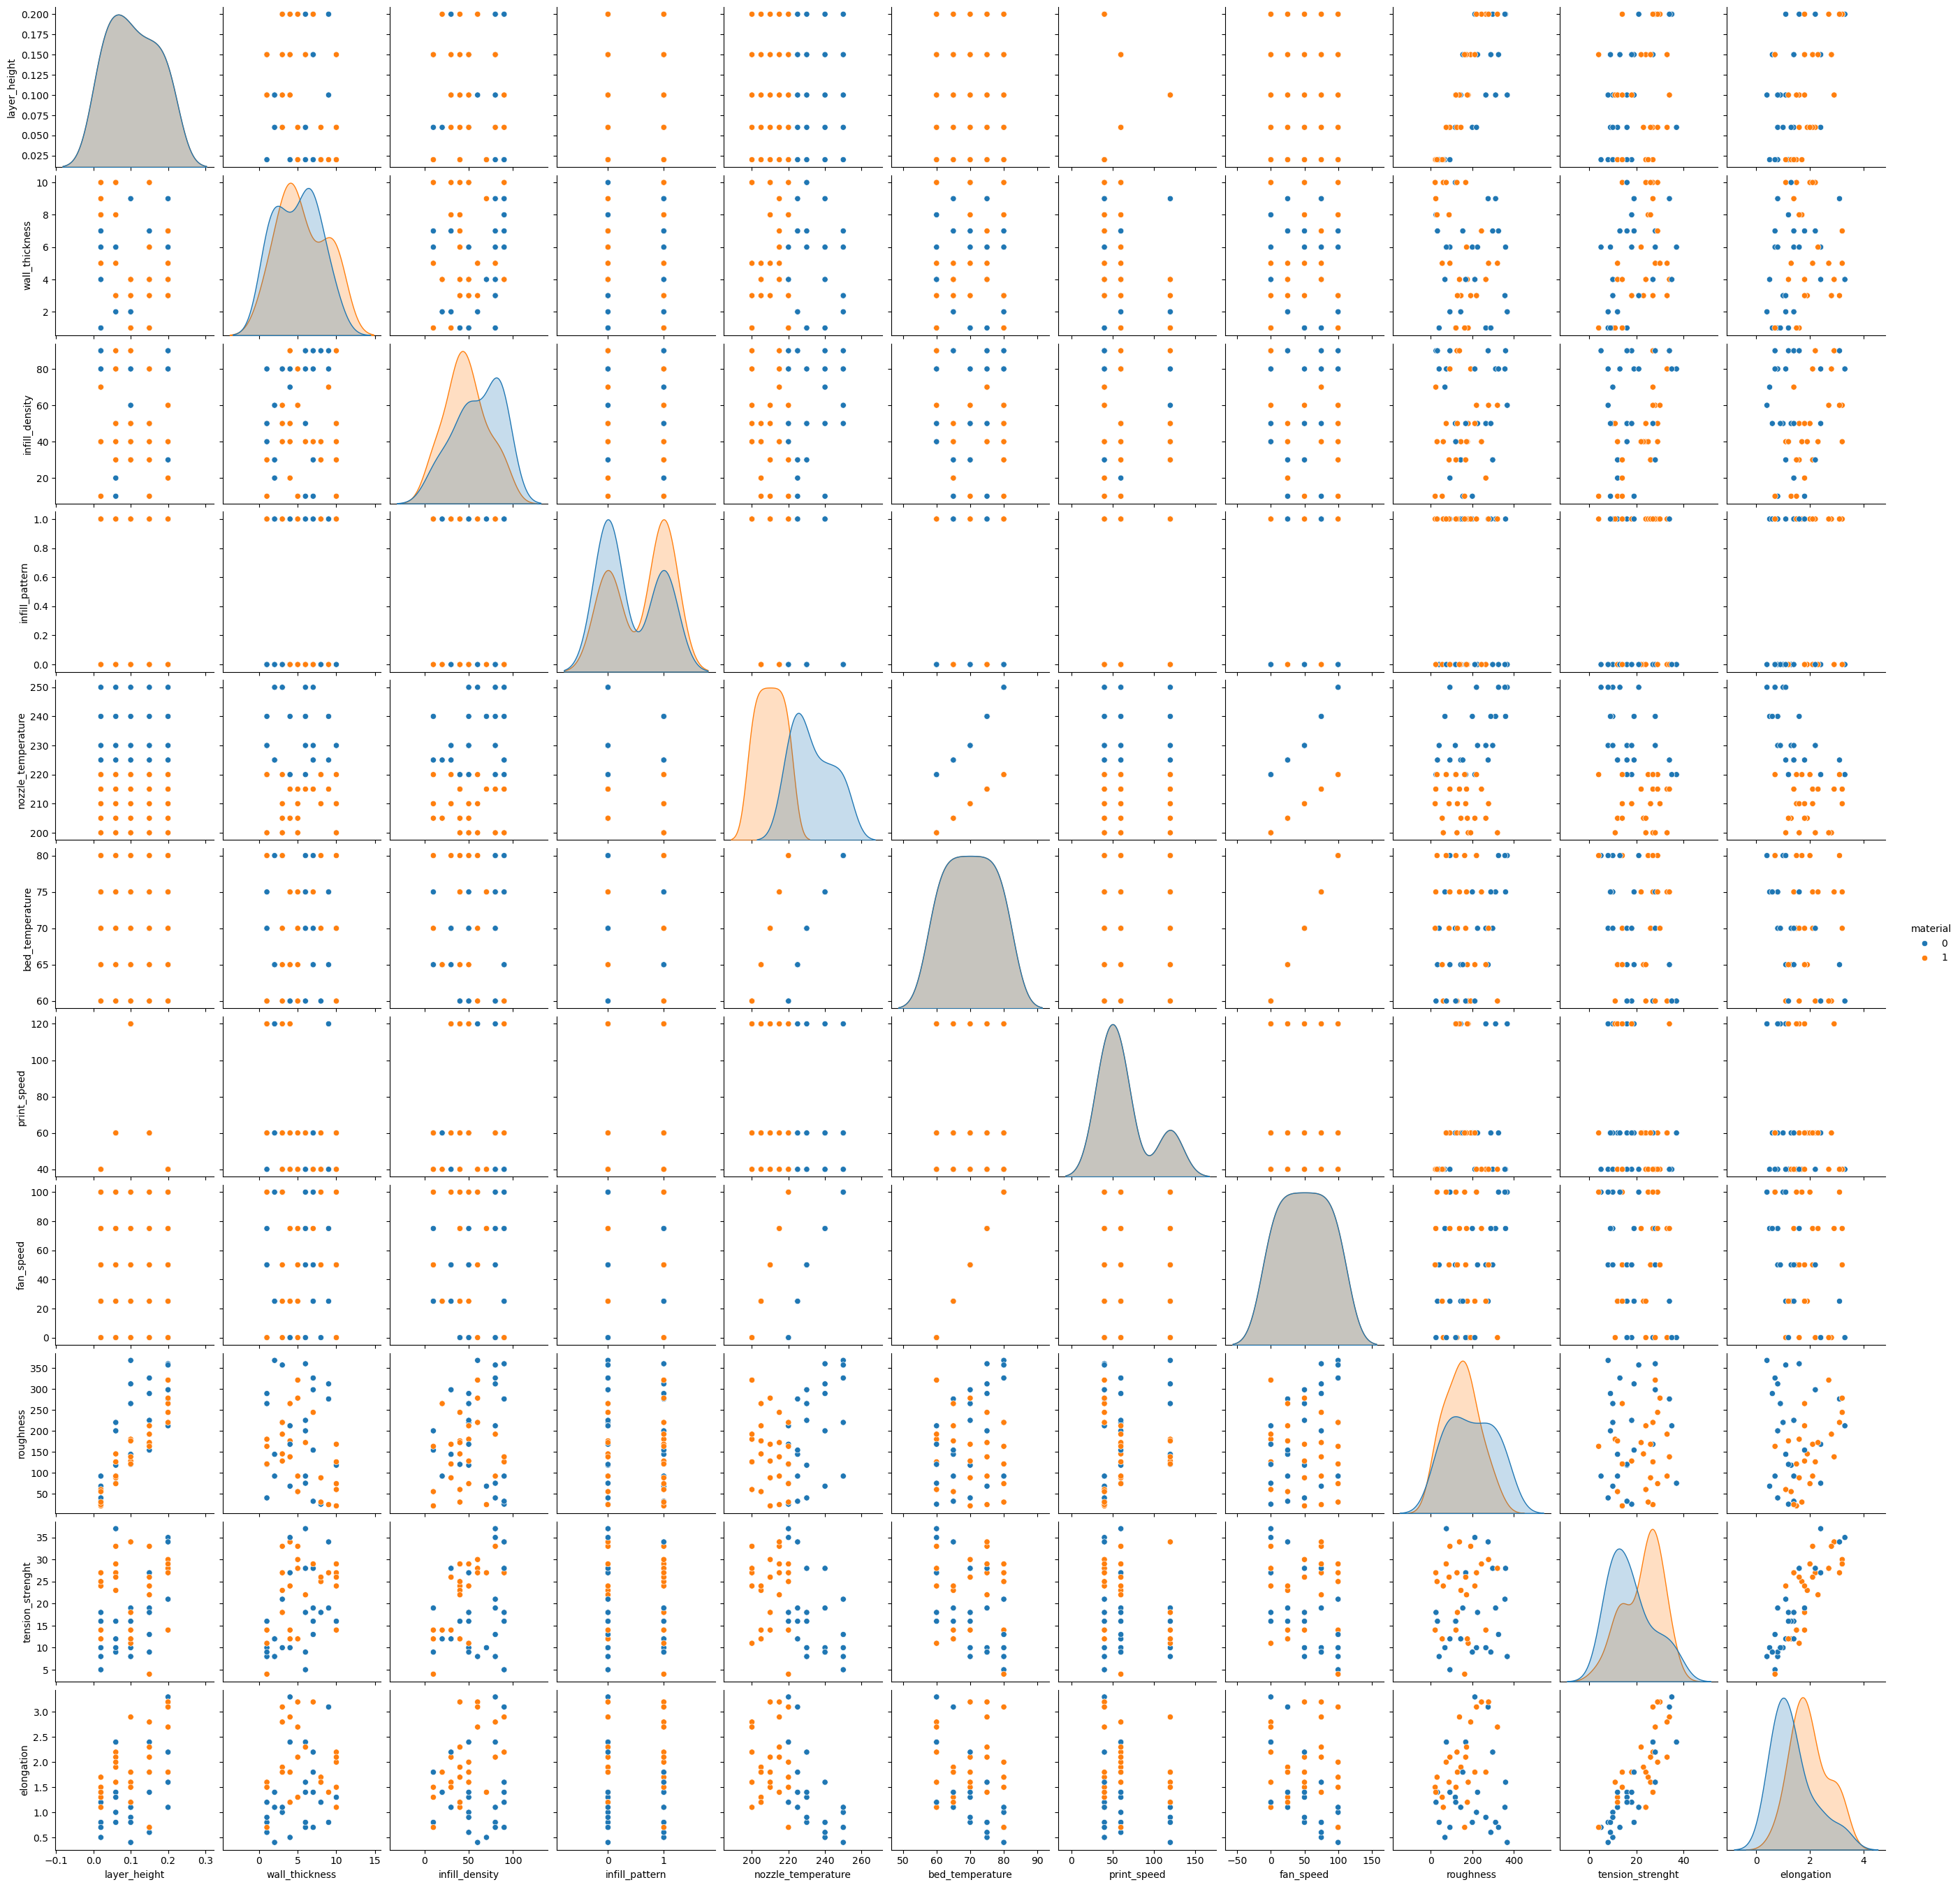

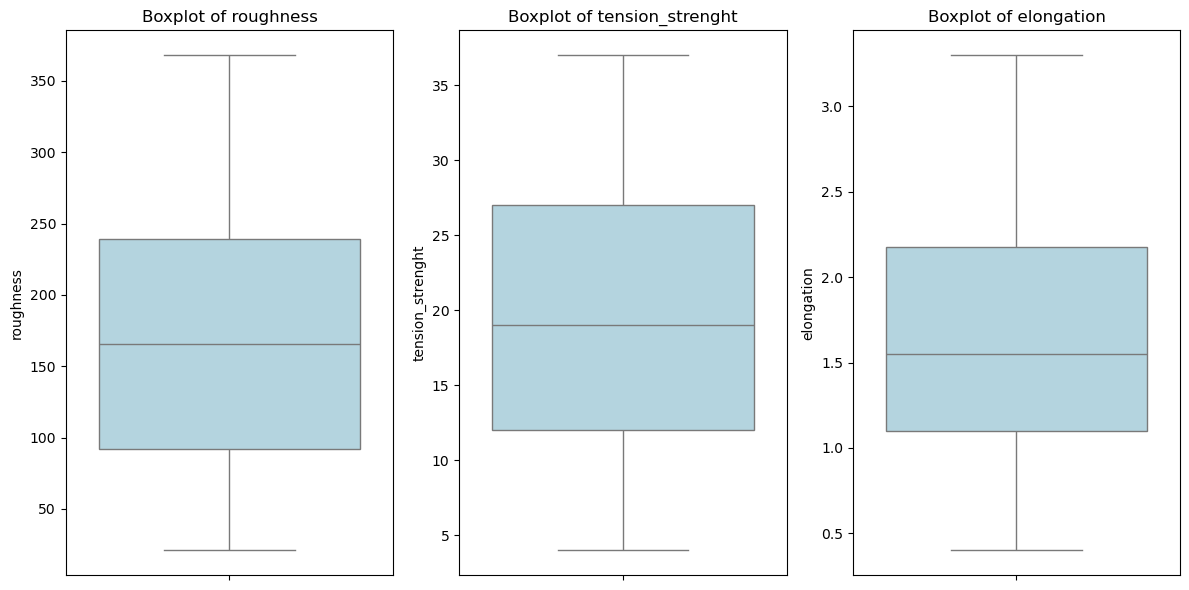

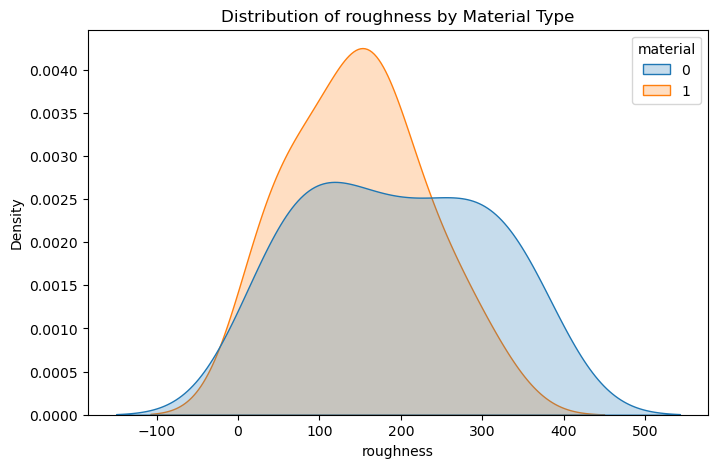

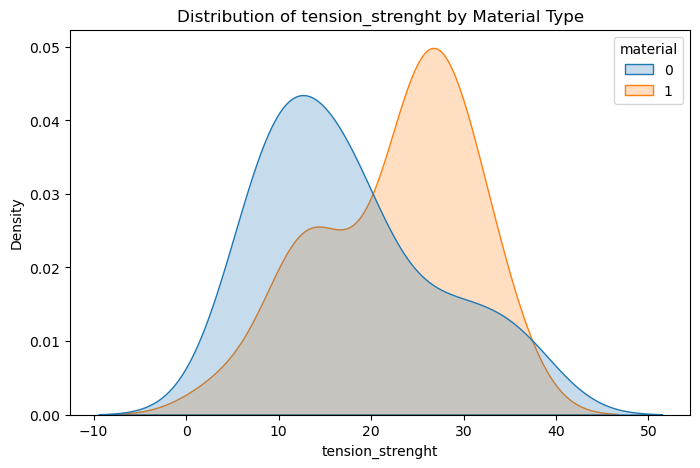

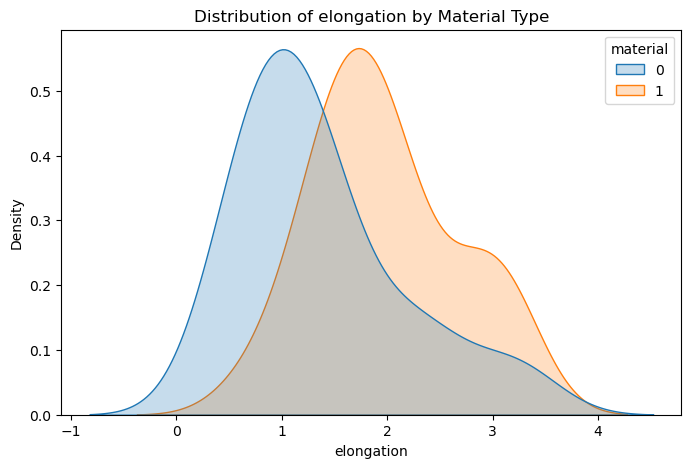

In [144]:
# EDA

# Correlation Heatmap to Show how Strongly Variables are Related to Each Other
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Scatterplot Matrix to Visualize Relationships Between Multiple Variables
sns.pairplot(data, hue="material", diag_kind="kde")
plt.show()

# Boxplot to visualize spread and outliers
plt.figure(figsize=(12, 6))
target_vars = ['roughness', 'tension_strenght', 'elongation']

for i, col in enumerate(target_vars, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Dsitributions of target variables by material
for col in ['roughness', 'tension_strenght', 'elongation']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=data, x=col, hue="material", fill=True, common_norm=False)
    plt.title(f'Distribution of {col} by Material Type')
    plt.show()

Linear Regression Metrics:
Mean Absolute Error (MAE): 27.4541
Mean Squared Error (MSE): 1283.3965
Root Mean Squared Error (RMSE): 35.8245
R-squared (R²): 0.8648

XGBoost Regression Metrics:
Mean Absolute Error (MAE): 20.5193
Mean Squared Error (MSE): 614.0618
Root Mean Squared Error (RMSE): 24.7803
R-squared (R²): 0.9353



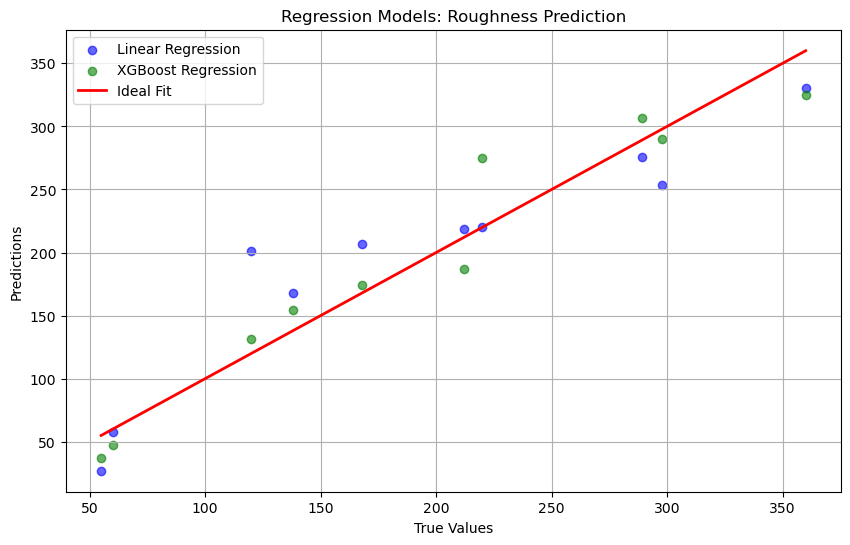

In [168]:
# Modeling Roughness
X = data.drop(columns=['roughness', 'infill_pattern', 'infill_density', 'wall_thickness'])
y = data[['roughness']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
standard_scaler = StandardScaler()
X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)

# Train Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Model Engineering
# Train XGBRegressor with Hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.001,
    reg_lambda=1.5
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Metrics
def print_metrics(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} Regression Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}\n")

print_metrics("Linear", y_test, y_pred_linear)
print_metrics("XGBoost", y_test, y_pred_xgb)

# Plot Roughness
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.6, label='Linear Regression')
plt.scatter(y_test, y_pred_xgb, color='green', alpha=0.6, label='XGBoost Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Fit')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression Models: Roughness Prediction')
plt.legend()
plt.grid(True)
plt.show()

Best Ridge Alpha: 1.438449888287663
Best Lasso Alpha: 0.008858667904100823

Linear Regression Metrics:
Mean Absolute Error (MAE): 0.4136
Mean Squared Error (MSE): 0.1883
Root Mean Squared Error (RMSE): 0.4339
R-squared (R²): 0.6714

Ridge Regression Metrics:
Mean Absolute Error (MAE): 0.4174
Mean Squared Error (MSE): 0.1944
Root Mean Squared Error (RMSE): 0.4409
R-squared (R²): 0.6607

Lasso Regression Metrics:
Mean Absolute Error (MAE): 0.4176
Mean Squared Error (MSE): 0.1932
Root Mean Squared Error (RMSE): 0.4395
R-squared (R²): 0.6628



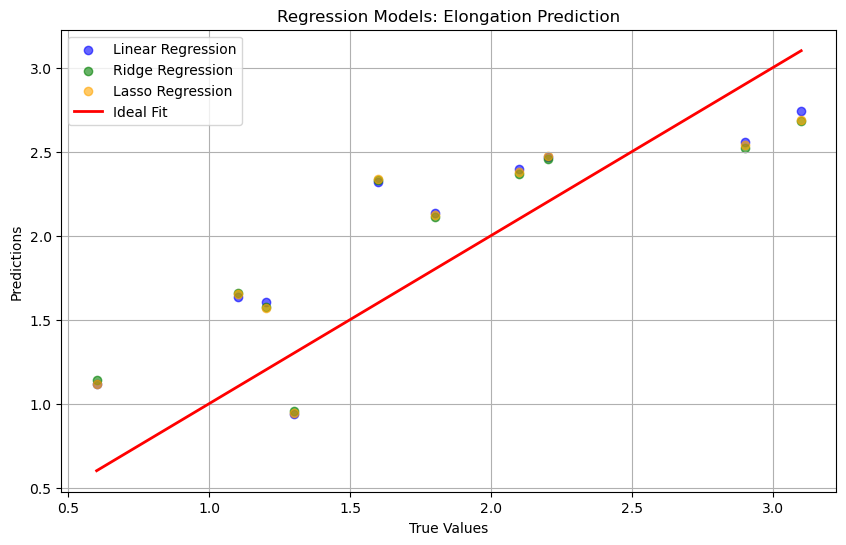

In [148]:
# Modeling Elongation
X2 = data.drop(columns=['elongation', 'nozzle_temperature', 'material', 'fan_speed', 'bed_temperature', 'print_speed'])
y2 = data[['elongation']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=100)
standard_scaler = StandardScaler()
X_train2 = pd.DataFrame(standard_scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2 = pd.DataFrame(standard_scaler.transform(X_test2), columns=X_test2.columns)

# algorithms
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso(max_iter=10000)

# Linear Regression
linear_model.fit(X_train2, y_train2)
y_pred_linear = linear_model.predict(X_test2)

# Model Engneering
# Ridge Regression with Hyperparameter Tuning
ridge_params = {'alpha': np.logspace(-3, 3, 20)}
ridge_cv = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train2, y_train2)
best_ridge = ridge_cv.best_estimator_
y_pred_ridge = best_ridge.predict(X_test2)

# Lasso Regression with Hyperparameter Tuning
lasso_params = {'alpha': np.logspace(-3, 3, 20)}
lasso_cv = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train2, y_train2)
best_lasso = lasso_cv.best_estimator_
y_pred_lasso = best_lasso.predict(X_test2)

print(f"Best Ridge Alpha: {ridge_cv.best_params_['alpha']}")
print(f"Best Lasso Alpha: {lasso_cv.best_params_['alpha']}\n")

# Calculate Metrics
def print_metrics(model_name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{model_name} Regression Metrics:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}\n")

print_metrics("Linear", y_test2, y_pred_linear)
print_metrics("Ridge", y_test2, y_pred_ridge)
print_metrics("Lasso", y_test2, y_pred_lasso)

plt.figure(figsize=(10, 6))
plt.scatter(y_test2, y_pred_linear, color='blue', alpha=0.6, label='Linear Regression')
plt.scatter(y_test2, y_pred_ridge, color='green', alpha=0.6, label='Ridge Regression')
plt.scatter(y_test2, y_pred_lasso, color='orange', alpha=0.6, label='Lasso Regression')
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], color='red', lw=2, label='Ideal Fit')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression Models: Elongation Prediction')
plt.legend()
plt.grid(True)
plt.show()

Best Ridge Alpha: 1.629751
Best Lasso Alpha: 0.464159

Linear Regression Metrics:
Training MAE: 2.9917
Testing MAE: 4.0477
Training MSE: 14.0699
Testing MSE: 20.7874
Training RMSE: 3.7510
Testing RMSE: 4.5593
Training R²: 0.8267
Testing R²: 0.6312

Ridge Regression Metrics:
Training MAE: 2.9555
Testing MAE: 3.8251
Training MSE: 14.2895
Testing MSE: 18.4546
Training RMSE: 3.7801
Testing RMSE: 4.2959
Training R²: 0.8240
Testing R²: 0.6726

Lasso Regression Metrics:
Training MAE: 3.0131
Testing MAE: 3.6760
Training MSE: 14.9777
Testing MSE: 17.5217
Training RMSE: 3.8701
Testing RMSE: 4.1859
Training R²: 0.8155
Testing R²: 0.6891


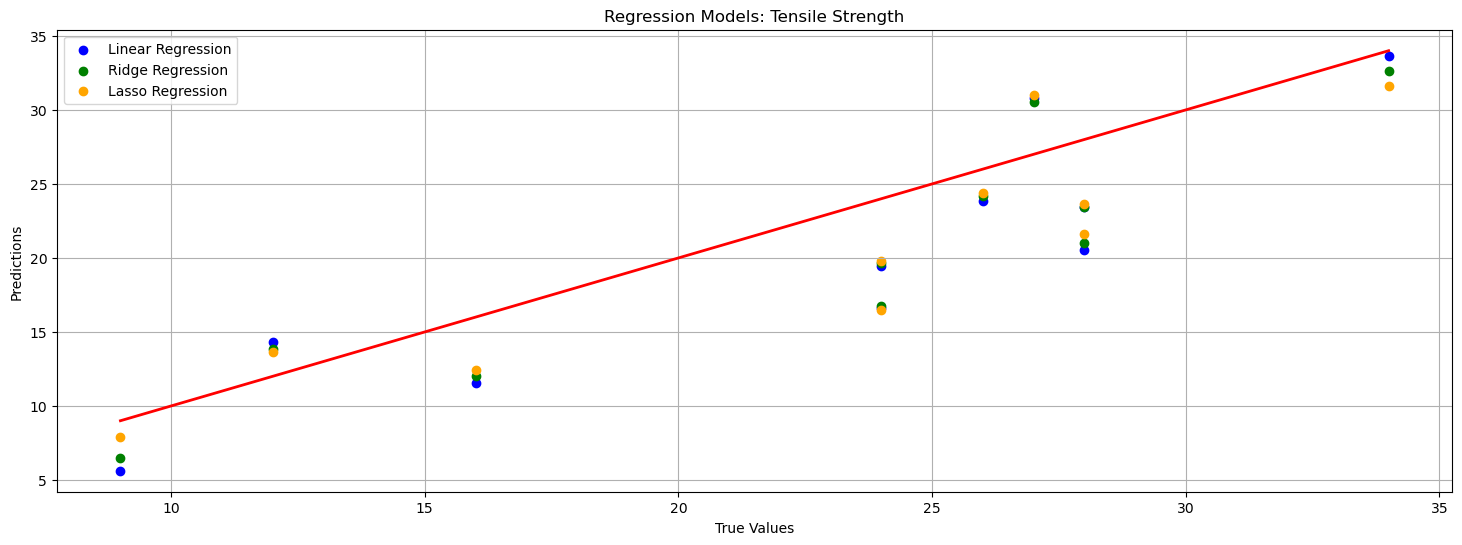

In [150]:
# Modeling Tensile Strength
X3 = data.drop(columns=['tension_strenght', 'nozzle_temperature', 'material', 'fan_speed', 'bed_temperature', 'print_speed'])
y3 = data[['tension_strenght']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=100)
standard_scaler = StandardScaler()
X_train3 = pd.DataFrame(standard_scaler.fit_transform(X_train3), columns=X_train3.columns)
X_test3 = pd.DataFrame(standard_scaler.transform(X_test3), columns=X_test3.columns)

# Algorithms
LR_model3 = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso(max_iter=5000)

# Linear Regression
LR_model3.fit(X_train3, y_train3)
y_train_pred3 = LR_model3.predict(X_train3)
y_test_pred3 = LR_model3.predict(X_test3)

# Model Engineering
# Ridge Regression with Hyperparameter Tuning
ridge_params = {'alpha': np.logspace(-3, 3, 100)}
ridge_cv = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train3, y_train3)
best_ridge_alpha = ridge_cv.best_params_['alpha']
ridge_best = Ridge(alpha=best_ridge_alpha)
ridge_best.fit(X_train3, y_train3)
y_train_ridge = ridge_best.predict(X_train3)
y_test_ridge = ridge_best.predict(X_test3)

# Lasso Regression with Hyperparameter Tuning
lasso_params = {'alpha': np.logspace(-3, 3, 100)}
lasso_cv = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train3, y_train3)
best_lasso_alpha = lasso_cv.best_params_['alpha']
lasso_best = Lasso(alpha=best_lasso_alpha, max_iter=5000)
lasso_best.fit(X_train3, y_train3)
y_train_lasso = lasso_best.predict(X_train3)
y_test_lasso = lasso_best.predict(X_test3)

# Calculate Metrics
def compute_metrics(y_train, y_train_pred, y_test, y_test_pred):
    return {
        "Training MAE": mean_absolute_error(y_train, y_train_pred),
        "Testing MAE": mean_absolute_error(y_test, y_test_pred),
        "Training MSE": mean_squared_error(y_train, y_train_pred),
        "Testing MSE": mean_squared_error(y_test, y_test_pred),
        "Training RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Testing RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Training R²": r2_score(y_train, y_train_pred),
        "Testing R²": r2_score(y_test, y_test_pred),
    }

linear_metrics = compute_metrics(y_train3, y_train_pred3, y_test3, y_test_pred3)
ridge_metrics = compute_metrics(y_train3, y_train_ridge, y_test3, y_test_ridge)
lasso_metrics = compute_metrics(y_train3, y_train_lasso, y_test3, y_test_lasso)

print(f"Best Ridge Alpha: {best_ridge_alpha:.6f}")
print(f"Best Lasso Alpha: {best_lasso_alpha:.6f}\n")

print("Linear Regression Metrics:")
for k, v in linear_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nRidge Regression Metrics:")
for k, v in ridge_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nLasso Regression Metrics:")
for k, v in lasso_metrics.items():
    print(f"{k}: {v:.4f}")

# Plot Tensile Strength
plt.figure(figsize=(18, 6))
plt.scatter(y_test3, y_test_pred3, color='blue', label='Linear Regression')
plt.scatter(y_test3, y_test_ridge, color='green', label='Ridge Regression')
plt.scatter(y_test3, y_test_lasso, color='orange', label='Lasso Regression')
plt.plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], color='red', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Regression Models: Tensile Strength')
plt.legend()
plt.grid(True)
plt.show()

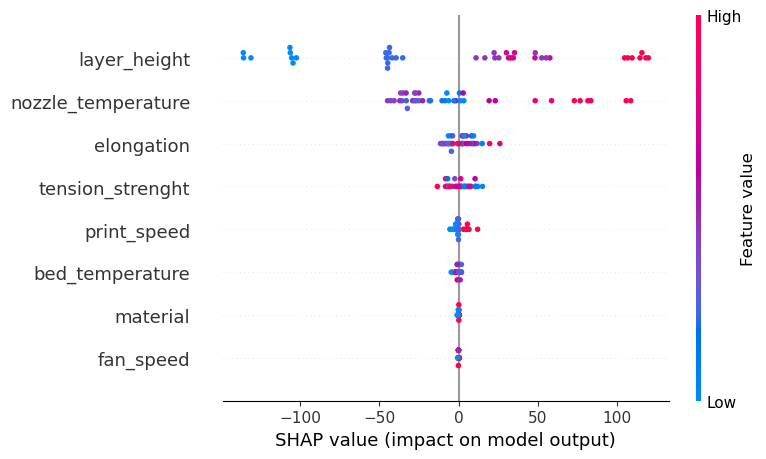

In [152]:
# Observations and Conclusions

# SHAP 
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0])
shap.summary_plot(shap_values, X_train)

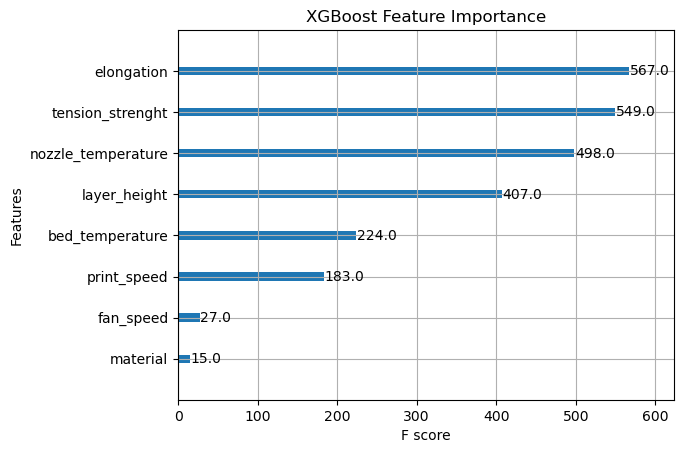

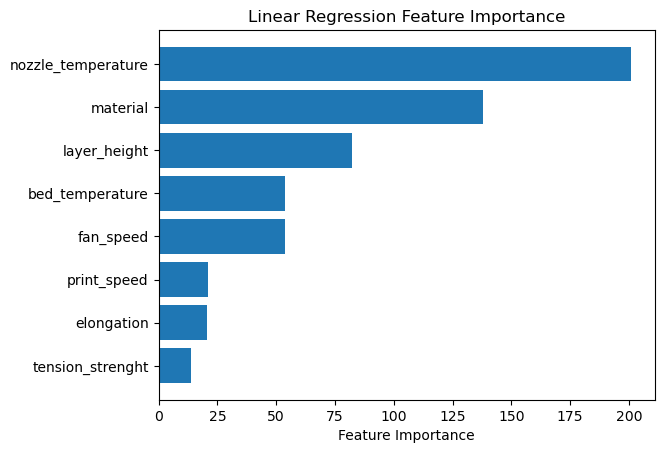

In [172]:
# Feature Importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

feature_importance = np.abs(linear_model.coef_).flatten()  
feature_names = X_train.columns  
sorted_idx = np.argsort(feature_importance)[::+1]

plt.barh(feature_names[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Linear Regression Feature Importance")
plt.show()

In [154]:
# Cross Validation
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print(f"Cross-validation R² scores: {scores}")
    print(f"Mean R² score: {scores.mean():.4f}")

cross_validate_model(linear_model, X_train, y_train)
cross_validate_model(xgb_model, X_train, y_train)

Cross-validation R² scores: [0.88891946 0.73887043 0.4341544  0.78945053 0.77516922]
Mean R² score: 0.7253
Cross-validation R² scores: [0.91667473 0.68559545 0.72937191 0.79417157 0.83953929]
Mean R² score: 0.7931
